In [1]:
import torch
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.svm import SVC

In [3]:
# model_name = 'Qwen/Qwen3-1.7B'
model_name = 'Qwen/Qwen3-4B'
# model_name = 'Qwen/Qwen3-8B'

In [4]:
# Convert model name to filename format
model_filename = model_name.replace("/", "_").replace("\\", "_").replace(":", "_")

think_resid = torch.load(f'/mnt/SSD4/kartik/reasoning/residuals/residuals_think_{model_filename}.pt', weights_only=True)
no_think_resid = torch.load(f'/mnt/SSD4/kartik/reasoning/residuals/residuals_nothink_{model_filename}.pt', weights_only=True)

harmful_analysis_path = f'/mnt/SSD4/kartik/reasoning/harmful_analysis_{model_filename}.json'

In [5]:
with open(harmful_analysis_path, 'r') as f:
    harmful_analysis = json.load(f)

harmful_think_ids = []
harmful_nothink_ids = []
think_harmful_nothink_safe = []  # think is harmful, nothink is not harmful
both_safe = []  # both think and nothink are not harmful

for item in harmful_analysis:
    question_id = item['question_id']
    think_harmful = item['think_analysis'] == 'harmful'
    nothink_harmful = item['nothink_analysis'] == 'harmful'
    
    if think_harmful:
        harmful_think_ids.append(question_id)
    if nothink_harmful:
        harmful_nothink_ids.append(question_id)
    
    # Find cases where think is harmful but nothink is not
    if think_harmful and not nothink_harmful:
        think_harmful_nothink_safe.append(question_id)
    
    # Find cases where both are not harmful
    if not think_harmful and not nothink_harmful:
        both_safe.append(question_id)

print(f"Think harmful: {len(harmful_think_ids)} questions")
print(f"Nothink harmful: {len(harmful_nothink_ids)} questions")
print(f"Think harmful, nothink safe: {len(think_harmful_nothink_safe)} questions")
print(f"Both safe: {len(both_safe)} questions")

Think harmful: 11 questions
Nothink harmful: 7 questions
Think harmful, nothink safe: 7 questions
Both safe: 86 questions


In [6]:
def analyze_layers(analysis_type='linear', verbose=False, use_balanced=True):

    HN_idx, SS_idx = [], []                    # will store 0-based indices

    for it in harmful_analysis:
        i    = it["question_id"] - 1           # convert back to 0-based index
        h_T  = it["think_analysis"]   == "harmful"
        h_NT = it["nothink_analysis"] == "harmful"

        if  h_T and (not h_NT):    HN_idx.append(i)   # positive
        if (not h_T) and (not h_NT):  SS_idx.append(i)   # negative

    if verbose:
        print(f"HN={len(HN_idx)},  SS={len(SS_idx)},  total={len(HN_idx)+len(SS_idx)}")

    # Balance dataset if requested
    if use_balanced:
        min_size = min(len(HN_idx), len(SS_idx))
        # Randomly sample to balance classes
        np.random.seed(42)  # For reproducibility
        if len(HN_idx) > min_size:
            HN_idx = np.random.choice(HN_idx, size=min_size, replace=False).tolist()
        if len(SS_idx) > min_size:
            SS_idx = np.random.choice(SS_idx, size=min_size, replace=False).tolist()
        
        if verbose:
            print(f"After balancing: HN={len(HN_idx)}, SS={len(SS_idx)}, total={len(HN_idx)+len(SS_idx)}")

    # ─── 2. load residual tensors  (shape: N × 28 × 6 × 2048) ──────────────
    # replace with your own .npy or torch.load paths
    think_post     = think_resid['post'].numpy()       # float32
    nothink_post   = no_think_resid['post'].numpy()

    # ─── 3. extract final-token residual & Δ  ───────────────────────────────
    think_final   = think_post[:, :, -1, :]          # (100, 28, 2048)
    nothink_final = nothink_post[:, :, -1, :]
    delta         = think_final - nothink_final      # (100, 28, 2048)

    # slice positives & negatives
    X_pos = delta[HN_idx]                            # (balanced, 28, 2048)
    X_neg = delta[SS_idx]                            # (balanced, 28, 2048)
    y      = np.concatenate([np.ones(len(X_pos)), np.zeros(len(X_neg))])
    X      = np.concatenate([X_pos, X_neg], 0)       # (2*balanced, 28, 2048)

    if verbose:
        print(X.shape, y.shape)

    # ─── 4. vectorized training across all layers WITH 5-fold CV ────────────
    n_splits   = 5
    kfold      = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracy_mean = []
    accuracy_std  = []

    if verbose:
        print(f"Layer  {analysis_type.upper()} CV-Accuracy (mean ± std)")
    
    # Vectorized approach: train all layers in parallel for each fold
    all_fold_accuracies = []  # Will be shape (n_splits, 28)
    
    for train_idx, test_idx in kfold.split(X[:, 0, :], y):  # Use first layer for stratification
        fold_accuracies = []
        
        for L in range(28):
            X_L = X[:, L, :]                       # (balanced*2, 2048)
            
            if analysis_type == 'linear':
                # Linear classifier
                clf = LogisticRegression(max_iter=400, C=0.25)
                clf.fit(X_L[train_idx], y[train_idx])
                probs = clf.predict_proba(X_L[test_idx])[:, 1]
            elif analysis_type == 'mlp':
                # Neural network classifier
                clf = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42, alpha=0.01)
                clf.fit(X_L[train_idx], y[train_idx])
                probs = clf.predict_proba(X_L[test_idx])[:, 1]
            elif analysis_type == 'rbf':
                # RBF kernel SVM classifier
                clf = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
                clf.fit(X_L[train_idx], y[train_idx])
                probs = clf.predict_proba(X_L[test_idx])[:, 1]
            elif analysis_type == 'poly':
                # Polynomial kernel SVM classifier
                clf = SVC(kernel='poly', degree=3, C=1.0, gamma='scale', probability=True, random_state=42)
                clf.fit(X_L[train_idx], y[train_idx])
                probs = clf.predict_proba(X_L[test_idx])[:, 1]
            else:
                raise ValueError("analysis_type must be either 'linear', 'mlp', 'rbf', or 'poly'")
            
            preds = (probs > 0.5).astype(int)
            fold_accuracies.append(accuracy_score(y[test_idx], preds))
        
        all_fold_accuracies.append(fold_accuracies)
    
    # Convert to numpy array for easier computation
    all_fold_accuracies = np.array(all_fold_accuracies)  # Shape: (n_splits, 28)
    
    # Compute mean and std across folds for each layer
    accuracy_mean = np.mean(all_fold_accuracies, axis=0)
    accuracy_std = np.std(all_fold_accuracies, axis=0)

    if verbose:
        for L in range(28):
            print(f"Layer {L:02d}: {accuracy_mean[L]:.3f} ± {accuracy_std[L]:.3f}")

    # ─── 5. choose pivot layers: earliest 3 whose CV-Accuracy ≥ 0.90 ──────────
    pivot_layers = [L for L, m in enumerate(accuracy_mean) if m >= 0.90][:3]
    if len(pivot_layers) < 3:                      # fallback: just top-3
        pivot_layers = np.argsort(accuracy_mean)[-3:][::-1].tolist()

    if verbose:
        print(f"Selected pivot layers ({analysis_type.upper()} CV):", pivot_layers)

    return accuracy_mean, accuracy_std, pivot_layers

In [39]:
auroc_mean_linear, auroc_std_linear, pivot_layers_linear = analyze_layers('linear', verbose=True)
auroc_mean_nn, auroc_std_nn, pivot_layers_nn = analyze_layers('mlp')
auroc_mean_rbf, auroc_std_rbf, pivot_layers_rbf = analyze_layers('rbf')
auroc_mean_poly, auroc_std_poly, pivot_layers_poly = analyze_layers('poly')

HN=6,  SS=92,  total=98
After balancing: HN=6, SS=6, total=12
(12, 36, 4096) (12,)
Layer  LINEAR CV-Accuracy (mean ± std)
Layer 00: 0.633 ± 0.306
Layer 01: 0.433 ± 0.082
Layer 02: 0.533 ± 0.400
Layer 03: 0.433 ± 0.327
Layer 04: 0.433 ± 0.327
Layer 05: 0.433 ± 0.327
Layer 06: 0.433 ± 0.327
Layer 07: 0.533 ± 0.400
Layer 08: 0.600 ± 0.389
Layer 09: 0.533 ± 0.400
Layer 10: 0.500 ± 0.333
Layer 11: 0.433 ± 0.327
Layer 12: 0.500 ± 0.333
Layer 13: 0.500 ± 0.333
Layer 14: 0.700 ± 0.267
Layer 15: 0.533 ± 0.400
Layer 16: 0.733 ± 0.389
Layer 17: 0.667 ± 0.365
Layer 18: 0.933 ± 0.133
Layer 19: 0.833 ± 0.211
Layer 20: 0.667 ± 0.365
Layer 21: 0.733 ± 0.226
Layer 22: 0.667 ± 0.183
Layer 23: 0.667 ± 0.183
Layer 24: 0.667 ± 0.183
Layer 25: 0.500 ± 0.105
Layer 26: 0.567 ± 0.082
Layer 27: 0.567 ± 0.082
Selected pivot layers (LINEAR CV): [18, 19, 16]


/home/kartik/miniconda3/envs/uv-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kartik/miniconda3/envs/uv-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kartik/miniconda3/envs/uv-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/kartik/miniconda3/envs/uv-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
 

In [7]:
auroc_mean_linear, auroc_std_linear, pivot_layers_linear = analyze_layers('linear', use_balanced=False)
auroc_mean_nn, auroc_std_nn, pivot_layers_nn = analyze_layers('mlp', use_balanced=False)

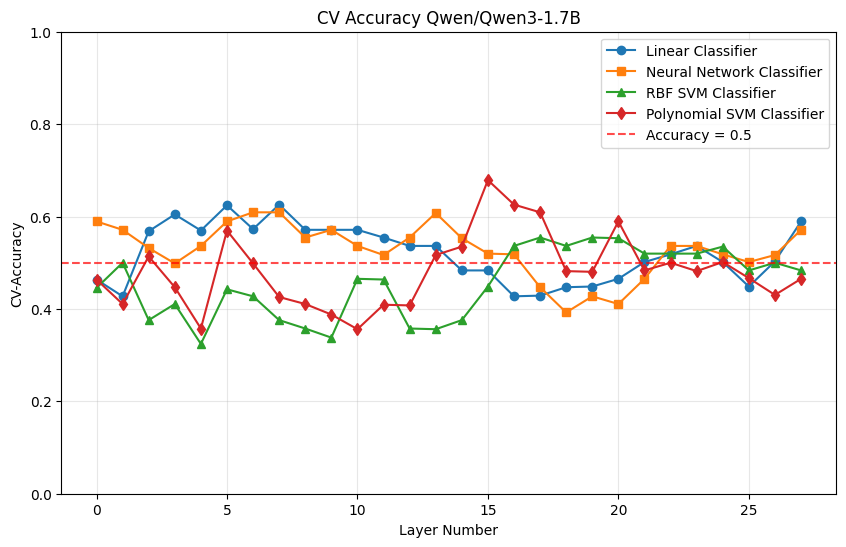

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(28), auroc_mean_linear, marker='o', label='Linear Classifier')
plt.plot(range(28), auroc_mean_nn, marker='s', label='Neural Network Classifier')
plt.plot(range(28), auroc_mean_rbf, marker='^', label='RBF SVM Classifier')
plt.plot(range(28), auroc_mean_poly, marker='d', label='Polynomial SVM Classifier')
plt.xlabel('Layer Number')
plt.ylabel('CV-Accuracy')
plt.title(f'CV Accuracy {model_name}')
plt.grid(True, alpha=0.3)
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.7, label='Accuracy = 0.5')
plt.legend()
plt.ylim(0, 1.0)
plt.show()

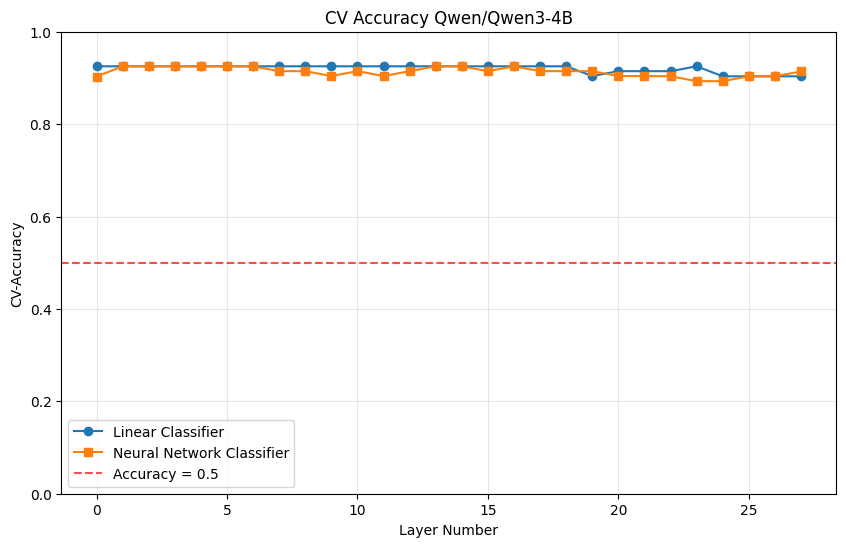

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(28), auroc_mean_linear, marker='o', label='Linear Classifier')
plt.plot(range(28), auroc_mean_nn, marker='s', label='Neural Network Classifier')
# plt.plot(range(28), auroc_mean_rbf, marker='^', label='RBF SVM Classifier')
# plt.plot(range(28), auroc_mean_poly, marker='d', label='Polynomial SVM Classifier')
plt.xlabel('Layer Number')
plt.ylabel('CV-Accuracy')
plt.title(f'CV Accuracy {model_name}')
plt.grid(True, alpha=0.3)
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.7, label='Accuracy = 0.5')
plt.legend()
plt.ylim(0, 1.0)
plt.show()

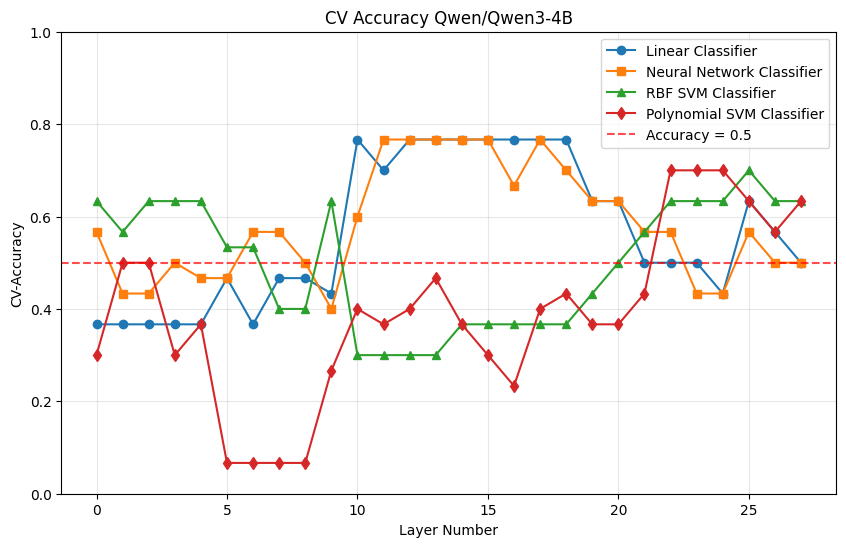

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(28), auroc_mean_linear, marker='o', label='Linear Classifier')
plt.plot(range(28), auroc_mean_nn, marker='s', label='Neural Network Classifier')
plt.plot(range(28), auroc_mean_rbf, marker='^', label='RBF SVM Classifier')
plt.plot(range(28), auroc_mean_poly, marker='d', label='Polynomial SVM Classifier')
plt.xlabel('Layer Number')
plt.ylabel('CV-Accuracy')
plt.title(f'CV Accuracy {model_name}')
plt.grid(True, alpha=0.3)
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.7, label='Accuracy = 0.5')
plt.legend()
plt.ylim(0, 1.0)
plt.show()

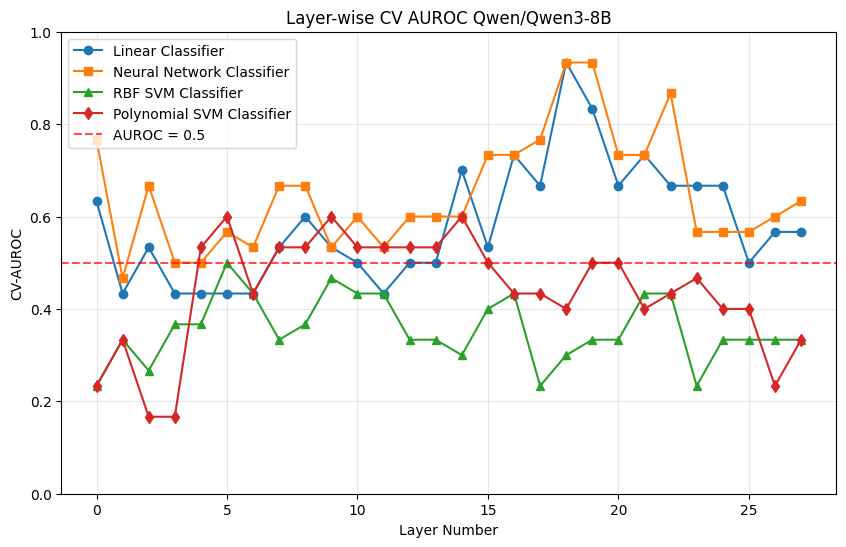

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(28), auroc_mean_linear, marker='o', label='Linear Classifier')
plt.plot(range(28), auroc_mean_nn, marker='s', label='Neural Network Classifier')
plt.plot(range(28), auroc_mean_rbf, marker='^', label='RBF SVM Classifier')
plt.plot(range(28), auroc_mean_poly, marker='d', label='Polynomial SVM Classifier')
plt.xlabel('Layer Number')
plt.ylabel('CV-AUROC')
plt.title(f'Layer-wise CV AUROC {model_name}')
plt.grid(True, alpha=0.3)
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.7, label='AUROC = 0.5')
plt.legend()
plt.ylim(0, 1.0)
plt.show()

In [43]:
import json

dataset_path = "playground/dataset/splits/harmful_test.json"

with open(dataset_path, 'r') as f:
    harmful_questions = json.load(f)

len(harmful_questions)

572